In [11]:
from dlcliche.notebook import *
from dlcliche.image import *
from dlcliche.math import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

deterministic_everything(123)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
#!wget https://raw.githubusercontent.com/dkumazaw/onecyclelr/master/onecyclelr.py
import onecyclelr 

In [13]:
import skimage.draw # line, polygon, circle, ellipse

class MoShapesDataset(Dataset):
    """TBD dataset."""

    def __init__(self, N, n_class=1, size=(224, 224), immutable=False, transform=None):
        self.N = N
        self.n_class = n_class
        self.width, self.height = size
        self.obj_width = size[0] // 6 # TBD
        self.obj_height = size[1] // 3 # TBD
        self.history= {}
        self.range_x, self.range_y, self.range_z = (0.1, 0.9), (0.1, 0.9), (0.5, 1.)
        self.immutable = immutable

        self.transform = transform
        self.transform_coords = torch.from_numpy

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        coords, colors, bg = self._params(idx, self.immutable)
        x, y = self.draw_image(coords, colors, bg), coords

        if self.transform:
            x = self.transform(x).float()
        if self.transform_coords:
            y = self.transform_coords(y).float()

        return x, y
    
    def random_color(self):
        return np.array([random.randint(0, 255) for _ in range(3)])

    def random_colors(self):
        return np.array([self.random_color() for _ in range(self.n_class)])

    def random_coord(self):
        return np.array([random.uniform(*self.range_x),
                                     random.uniform(*self.range_y),
                                     random.uniform(*self.range_z)])

    def random_coords(self):
        return np.array([self.random_coord() for _ in range(self.n_class)])

    def _params(self, idx, immutable):
        if immutable and idx in self.history:
            coords, colors, bg = self.history[idx]
        else:
            coords, colors = self.random_coords(), self.random_colors()
            bg = self.random_color()
            self.history[idx] = (coords, colors, bg)
        return (coords, colors, bg)

    def _calc_ellipse_param(self, coord):
        cx, cy = self.width * coord[0], self.height * coord[1]
        w, h = self.obj_width * coord[2], self.obj_height * coord[2]
        x, y = cx - w//2, cy - h//2
        return x, y, w, h

    def filled_shape(self, coord):
        x, y, w, h = self._calc_ellipse_param(coord)
        return skimage.draw.ellipse(x, y, h, w,  shape=(self.width, self.height))

    def draw_image(self, coords, colors, bg, as_mask=False):
        # mask
        mask = np.zeros([self.width, self.height], dtype=np.uint8)
        for c, coord in enumerate(coords):
            rr, cc = self.filled_shape(coord)
            mask[rr, cc] = c + 1 # class number
        if as_mask:
            return mask
        
        # image := mask replaced class number with colors 
        bg_color = bg # np.array(bg).reshape([1, 1, 3])
        image = np.zeros([self.width, self.height, 3], dtype=np.uint8)
        image[mask == 0] = bg_color
        for c, color in enumerate(colors):
            image[mask == c + 1] = color
        return image
    
    def line_shape(self, coord, increment=0):
        x, y, w, h = self._calc_ellipse_param(coord)
        x, y, w, h = list(map(int, [x, y, w+increment, h+increment]))
        return skimage.draw.ellipse_perimeter(x, y, h, w, shape=(self.width, self.height))
    
    def draw_preds(self, image, coords):
        line_color = np.array([1., 0., 0.]) #if image is float else np.array([255, 0, 0])
        for c, coord in enumerate(coords):
            for i in range(5):
                rr, cc = self.line_shape(coord, increment=i)
                image[rr, cc, :] = line_color

0 (224, 224, 3) tensor([[0.1419, 0.1697, 0.7036]])
1 (224, 224, 3) tensor([[0.2277, 0.3698, 0.6669]])
2 (224, 224, 3) tensor([[0.1559, 0.3524, 0.7242]])
3 (224, 224, 3) tensor([[0.8289, 0.5587, 0.6327]])
4 (224, 224, 3) tensor([[0.1100, 0.8144, 0.8231]])
5 (224, 224, 3) tensor([[0.6807, 0.1661, 0.7435]])


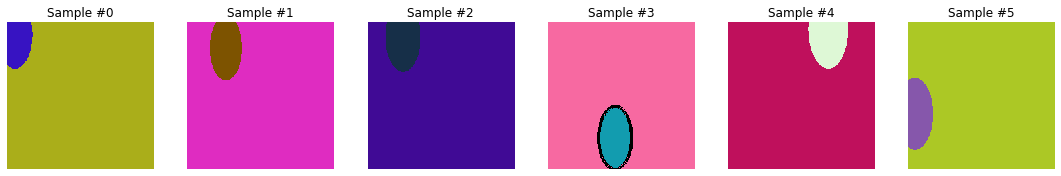

In [14]:
mo_ds = MoShapesDataset(100)
fig = plt.figure(figsize=(15, 8))

for i in range(len(mo_ds)):
    x, y = mo_ds[i]

    print(i, x.shape, y)

    if i == 3:
        mo_ds.draw_preds(x, (mo_ds.history[i][0]+np.array([0.01, 0.001, -0.002])))
    
    ax = plt.subplot(1, 6, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    plt.imshow(x)

    if i == 5:
        plt.show()
        break

In [15]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['coords']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'coords': torch.from_numpy(landmarks)}

In [16]:
N_TRAIN = 5000
N_VALID = 500
N = N_TRAIN + N_VALID

transformed_dataset = MoShapesDataset(N=N, transform=transforms.ToTensor())

for i in range(len(transformed_dataset)):
    x, y = transformed_dataset[i]
    print(i, x.size(), y.size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([1, 3])
1 torch.Size([3, 224, 224]) torch.Size([1, 3])
2 torch.Size([3, 224, 224]) torch.Size([1, 3])
3 torch.Size([3, 224, 224]) torch.Size([1, 3])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 3])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 3])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 3])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 3])


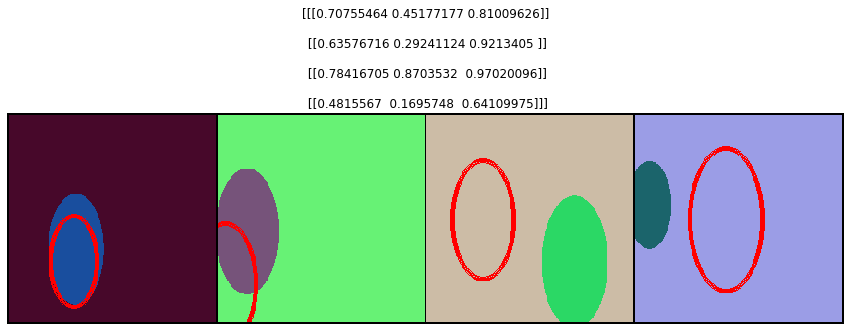

In [17]:
def show_batch(sample_batched, preds=None, ds=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, coords_batch = \
            sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    images_batch = [x.numpy().transpose((1, 2, 0)) for x in images_batch]
    if preds is not None:
        preds = [x.numpy() for x in preds]
        for img, pred in zip(images_batch, preds):
            ds.draw_preds(img, pred)

    images_batch = [transforms.ToTensor()(x) for x in images_batch]
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title(str(coords_batch.numpy()))


dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

fake_preds = torch.Tensor([
    [[0.7565, 0.4196, 0.6391]],
    [[0.8828, 0.1762, 0.8553]],
    [[0.5731, 0.4122, 0.8475]],
    [[0.5875, 0.6041, 1.0176]]]).float()

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(15, 8))
        show_batch(sample_batched, preds=fake_preds, ds=transformed_dataset)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [18]:
image_datasets = {x: MoShapesDataset(N=n,
                                           transform=transforms.ToTensor(),
                                           immutable=immutable)
                  for x, n, immutable in zip(['train', 'val'], [N_TRAIN, N_VALID], [False, True])}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [24]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1), end='')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.squeeze(1).to(device) #### TODO for now

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'  {phase} Loss: {epoch_loss:.4f}', end='')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.MSELoss()

n_epochs = 25
lr = 0.0003

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
#scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
scheduler = onecyclelr.OneCycleLR(optimizer_ft, n_epochs, lr_range=(lr/10, lr))

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=n_epochs)

Epoch 0/24
train Loss: 0.0479
val Loss: 0.0103

Epoch 1/24
train Loss: 0.0048
val Loss: 0.0022

Epoch 2/24
train Loss: 0.0015
val Loss: 0.0009

Epoch 3/24
train Loss: 0.0009
val Loss: 0.0008

Epoch 4/24
train Loss: 0.0008
val Loss: 0.0008

Epoch 5/24
train Loss: 0.0008
val Loss: 0.0012

Epoch 6/24
train Loss: 0.0008
val Loss: 0.0005

Epoch 7/24
train Loss: 0.0009
val Loss: 0.0004

Epoch 8/24
train Loss: 0.0007
val Loss: 0.0006

Epoch 9/24
train Loss: 0.0006
val Loss: 0.0012

Epoch 10/24
train Loss: 0.0007
val Loss: 0.0003

Epoch 11/24
train Loss: 0.0006
val Loss: 0.0010

Epoch 12/24
train Loss: 0.0008
val Loss: 0.0002

Epoch 13/24
train Loss: 0.0003
val Loss: 0.0004

Epoch 14/24
train Loss: 0.0003
val Loss: 0.0005

Epoch 15/24
train Loss: 0.0002
val Loss: 0.0002

Epoch 16/24
train Loss: 0.0002
val Loss: 0.0001

Epoch 17/24
train Loss: 0.0001
val Loss: 0.0002

Epoch 18/24
train Loss: 0.0001
val Loss: 0.0001

Epoch 19/24
train Loss: 0.0001
val Loss: 0.0001

Epoch 20/24
train Loss: 0.0000

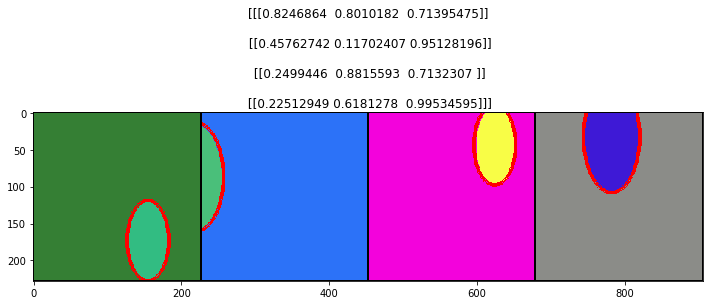

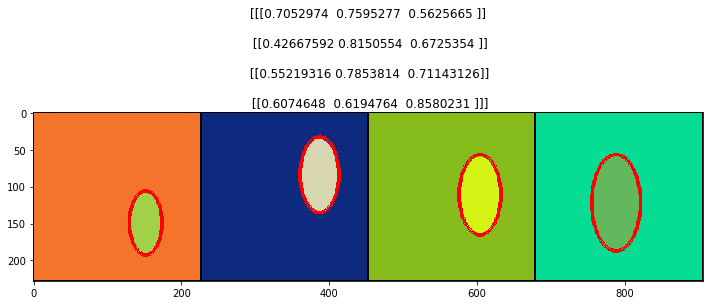

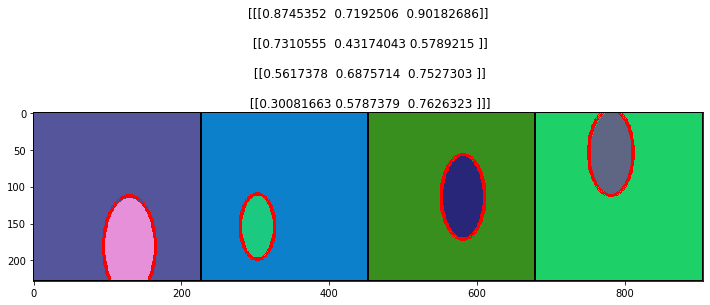

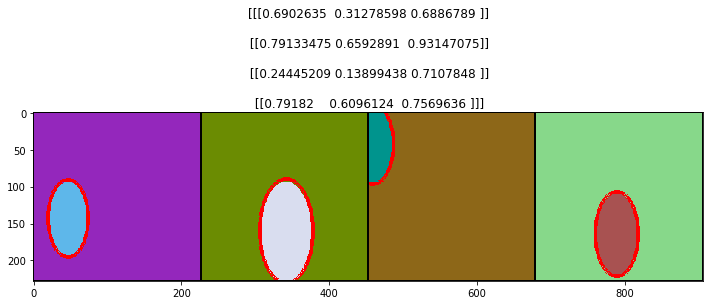

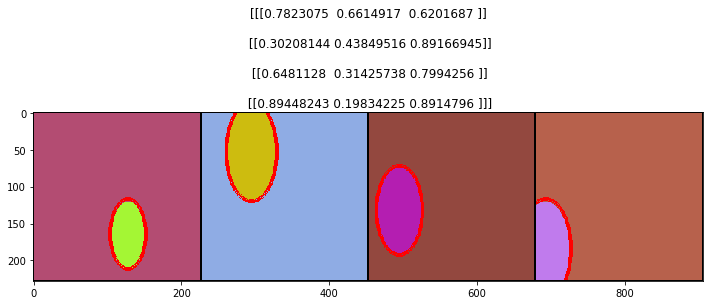

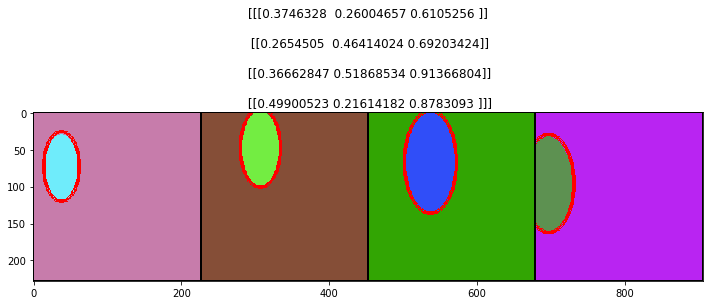

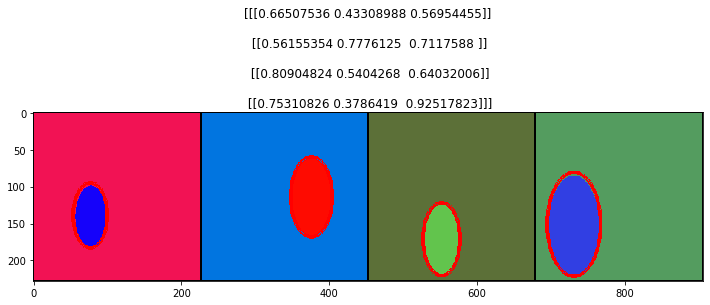

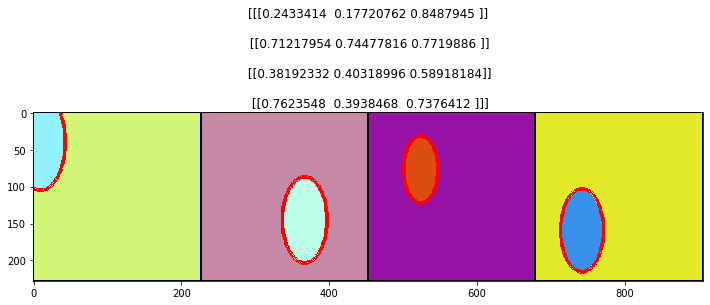

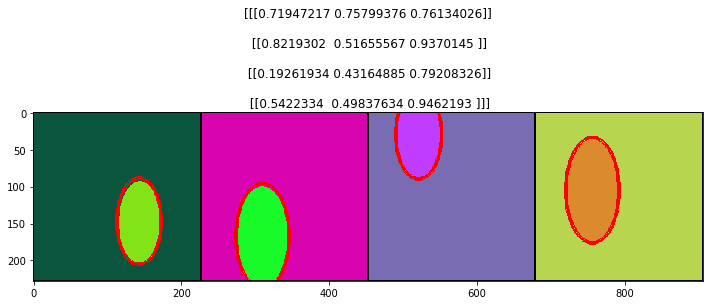

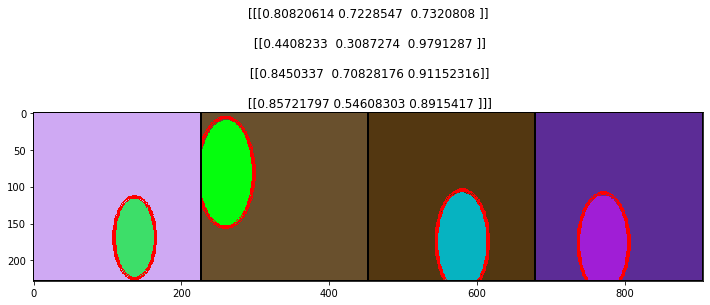

In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = outputs.cpu().unsqueeze(1)
            def A(t): return t.cpu() #.clamp(0., 1.)

            fig = plt.figure(figsize=(12, 8))
            show_batch((A(inputs), A(labels)), preds=A(outputs), ds=image_datasets['val'])
            plt.show()
            
            if i >= 9: break

        model.train(mode=was_training)


visualize_model(model_ft)

## SGD

In [25]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.MSELoss()

n_epochs = 25
lr = 0.0003

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.AdamW(model_ft.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#scheduler = onecyclelr.OneCycleLR(optimizer_ft, n_epochs, lr_range=(lr/10, lr))

model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=n_epochs)

Epoch 0/24  train Loss: 0.0495  val Loss: 0.0349
Epoch 1/24  train Loss: 0.0239  val Loss: 0.0120
Epoch 2/24  train Loss: 0.0179  val Loss: 0.0070
Epoch 3/24  train Loss: 0.0140  val Loss: 0.0099
Epoch 4/24  train Loss: 0.0105  val Loss: 0.0052
Epoch 5/24  train Loss: 0.0080  val Loss: 0.0063
Epoch 6/24  train Loss: 0.0072  val Loss: 0.0047
Epoch 7/24  train Loss: 0.0035  val Loss: 0.0031
Epoch 8/24  train Loss: 0.0036  val Loss: 0.0033
Epoch 9/24  train Loss: 0.0034  val Loss: 0.0026
Epoch 10/24  train Loss: 0.0034  val Loss: 0.0024
Epoch 11/24  train Loss: 0.0031  val Loss: 0.0028
Epoch 12/24  train Loss: 0.0032  val Loss: 0.0026
Epoch 13/24  train Loss: 0.0033  val Loss: 0.0028
Epoch 14/24  train Loss: 0.0029  val Loss: 0.0023
Epoch 15/24  train Loss: 0.0030  val Loss: 0.0032
Epoch 16/24  train Loss: 0.0029  val Loss: 0.0026
Epoch 17/24  train Loss: 0.0030  val Loss: 0.0028
Epoch 18/24  train Loss: 0.0030  val Loss: 0.0026
Epoch 19/24  train Loss: 0.0029  val Loss: 0.0026
Epoch 20/2

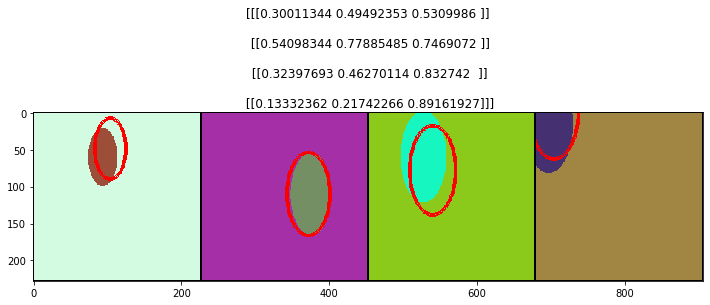

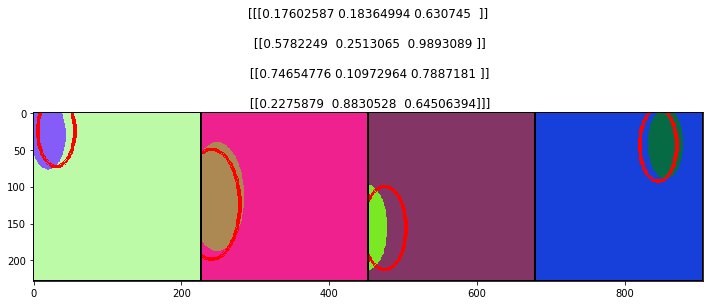

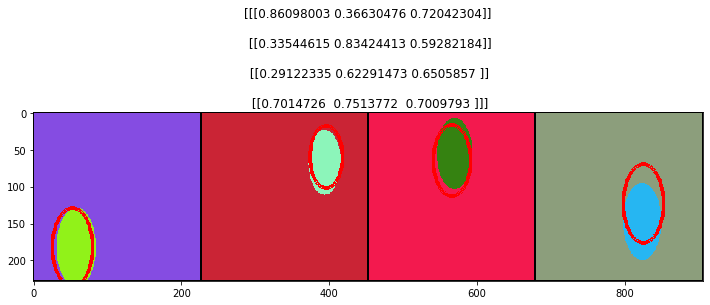

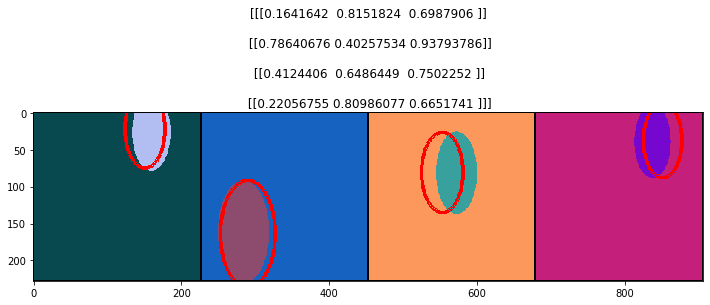

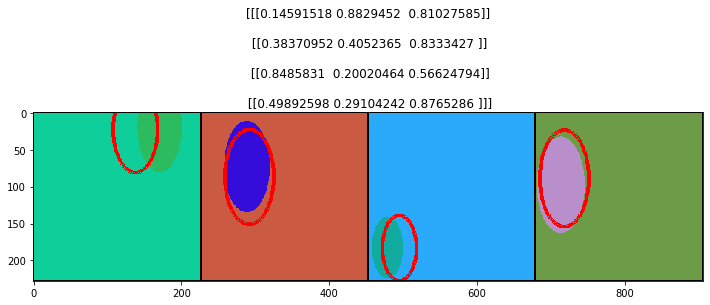

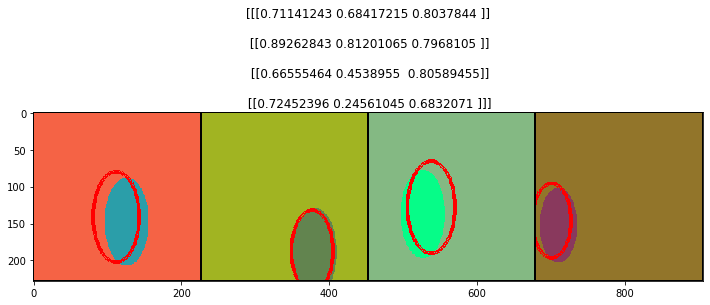

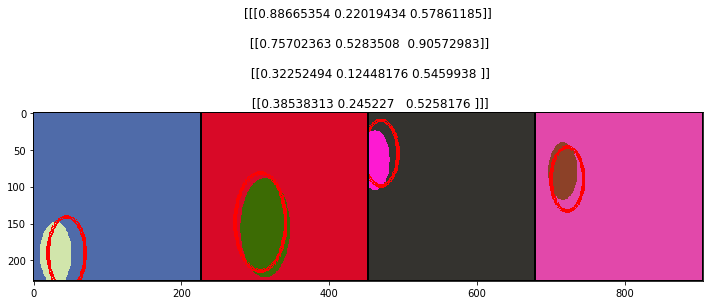

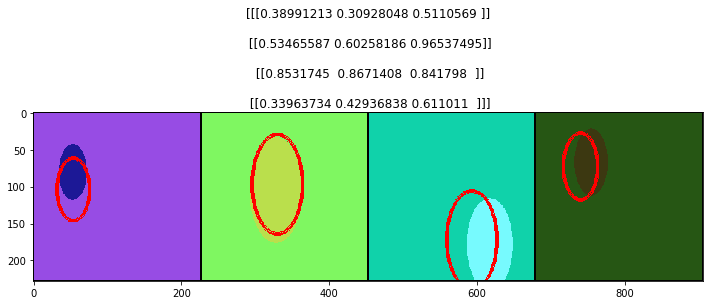

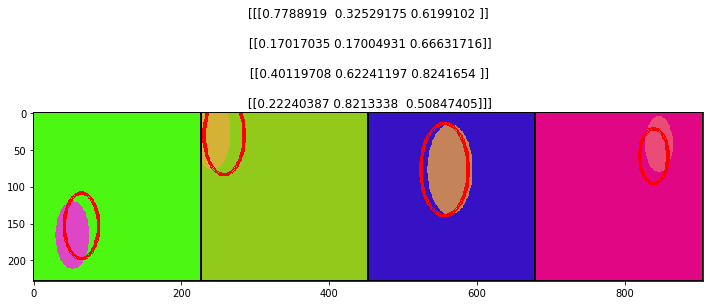

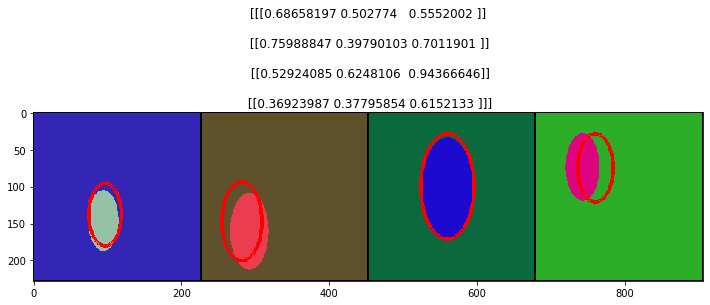

In [26]:
visualize_model(model_ft)

In [27]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.MSELoss()

n_epochs = 25
lr = 0.0003

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
#optimizer_ft = optim.AdamW(model_ft.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#scheduler = onecyclelr.OneCycleLR(optimizer_ft, n_epochs, lr_range=(lr/10, lr))

model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=n_epochs)

Epoch 0/24  train Loss: 0.0491  val Loss: 0.0367
Epoch 1/24  train Loss: 0.0267  val Loss: 0.0237
Epoch 2/24  train Loss: 0.0198  val Loss: 0.0178
Epoch 3/24  train Loss: 0.0178  val Loss: 0.0126
Epoch 4/24  train Loss: 0.0151  val Loss: 0.0097
Epoch 5/24  train Loss: 0.0141  val Loss: 0.0101
Epoch 6/24  train Loss: 0.0124  val Loss: 0.0089
Epoch 7/24  train Loss: 0.0095  val Loss: 0.0073
Epoch 8/24  train Loss: 0.0092  val Loss: 0.0061
Epoch 9/24  train Loss: 0.0092  val Loss: 0.0071
Epoch 10/24  train Loss: 0.0092  val Loss: 0.0064
Epoch 11/24  train Loss: 0.0088  val Loss: 0.0064
Epoch 12/24  train Loss: 0.0087  val Loss: 0.0060
Epoch 13/24  train Loss: 0.0086  val Loss: 0.0070
Epoch 14/24  train Loss: 0.0085  val Loss: 0.0067
Epoch 15/24  train Loss: 0.0084  val Loss: 0.0063
Epoch 16/24  train Loss: 0.0088  val Loss: 0.0056
Epoch 17/24  train Loss: 0.0084  val Loss: 0.0068
Epoch 18/24  train Loss: 0.0084  val Loss: 0.0075
Epoch 19/24  train Loss: 0.0084  val Loss: 0.0064
Epoch 20/2

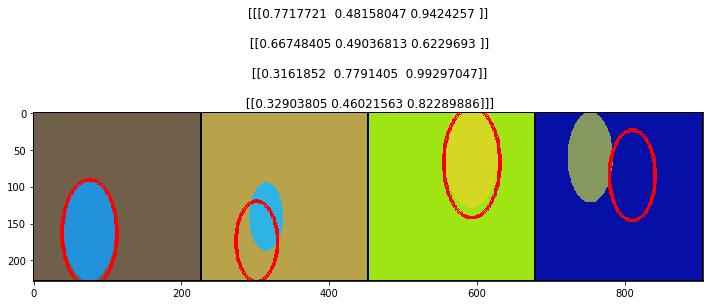

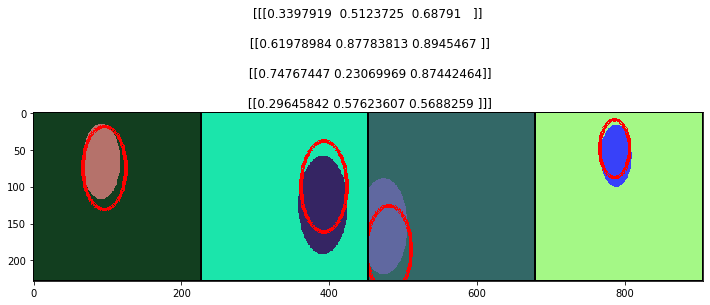

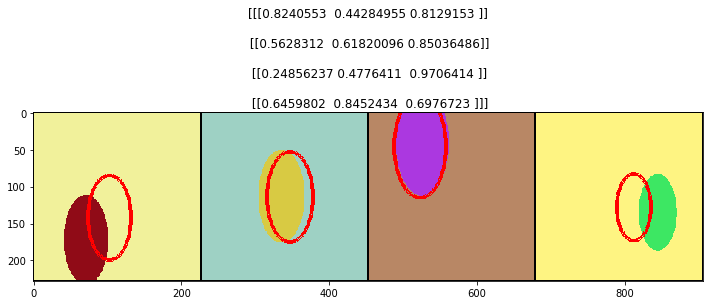

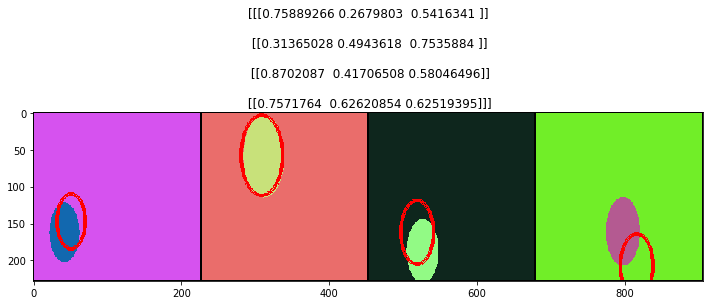

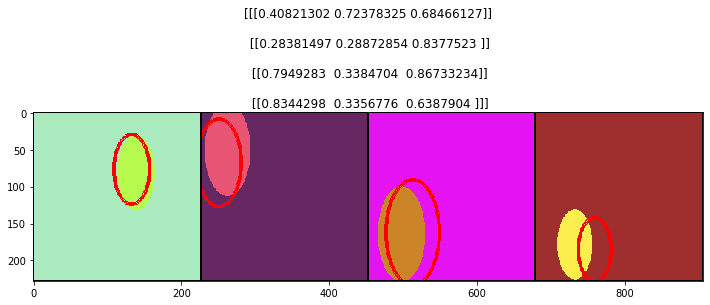

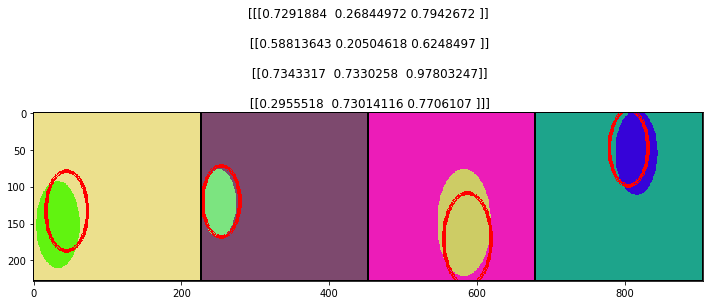

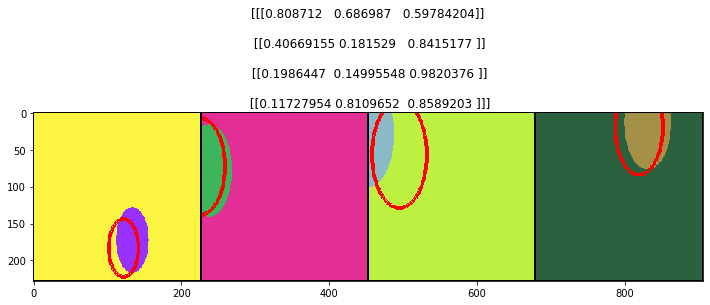

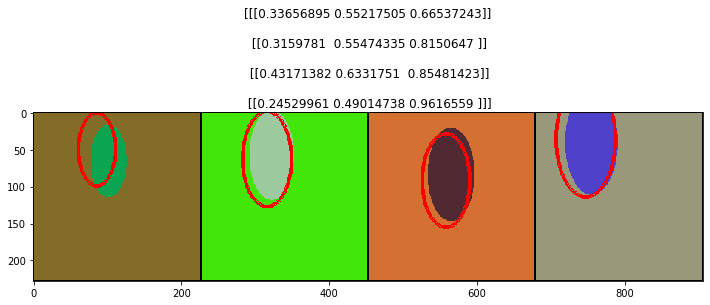

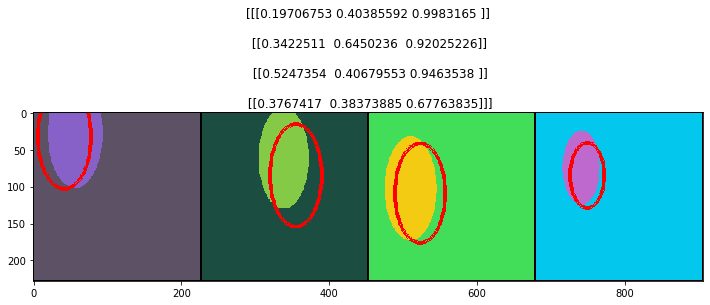

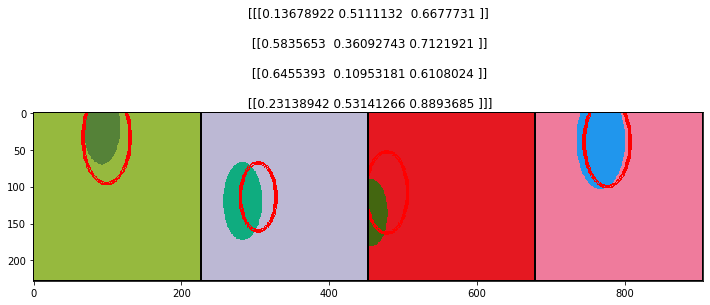

In [28]:
visualize_model(model_ft)

Epoch 0/24  train Loss: 0.0253  val Loss: 0.0024
Epoch 1/24  train Loss: 0.0017  val Loss: 0.0013
Epoch 2/24  train Loss: 0.0011  val Loss: 0.0012
Epoch 3/24  train Loss: 0.0014  val Loss: 0.0008
Epoch 4/24  train Loss: 0.0015  val Loss: 0.0005
Epoch 5/24  train Loss: 0.0016  val Loss: 0.0009
Epoch 6/24  train Loss: 0.0011  val Loss: 0.0006
Epoch 7/24  train Loss: 0.0016  val Loss: 0.0008
Epoch 8/24  train Loss: 0.0031  val Loss: 0.0032
Epoch 9/24  train Loss: 0.0012  val Loss: 0.0019
Epoch 10/24  train Loss: 0.0011  val Loss: 0.0002
Epoch 11/24  train Loss: 0.0016  val Loss: 0.0010
Epoch 12/24  train Loss: 0.0009  val Loss: 0.0004
Epoch 13/24  train Loss: 0.0005  val Loss: 0.0004
Epoch 14/24  train Loss: 0.0006  val Loss: 0.0005
Epoch 15/24  train Loss: 0.0005  val Loss: 0.0001
Epoch 16/24  train Loss: 0.0003  val Loss: 0.0002
Epoch 17/24  train Loss: 0.0003  val Loss: 0.0001
Epoch 18/24  train Loss: 0.0002  val Loss: 0.0002
Epoch 19/24  train Loss: 0.0002  val Loss: 0.0001
Epoch 20/2

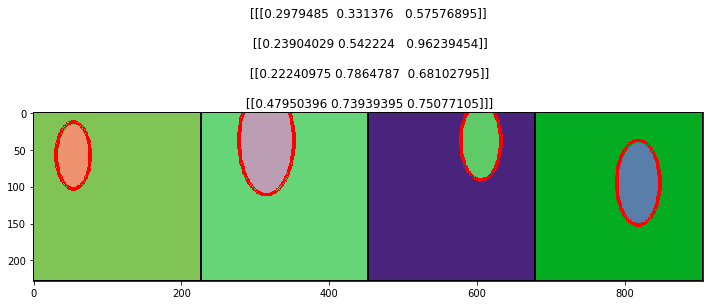

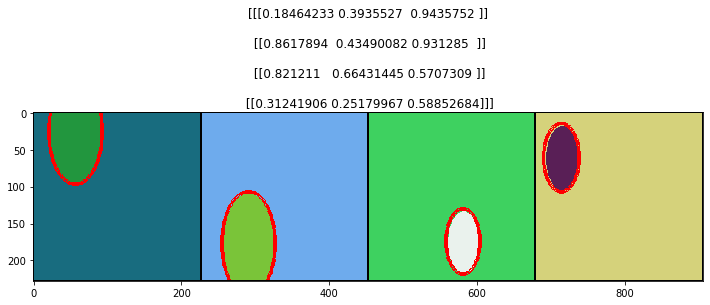

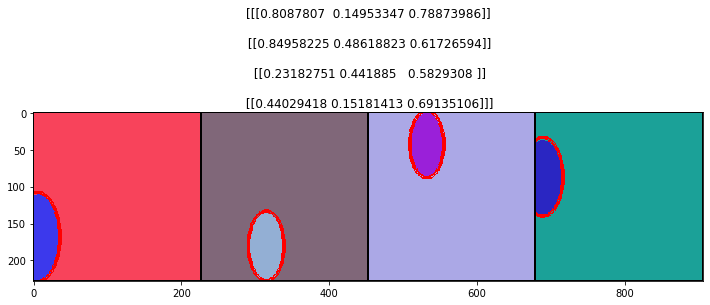

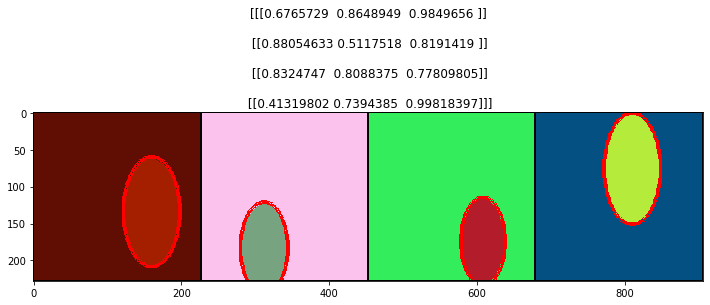

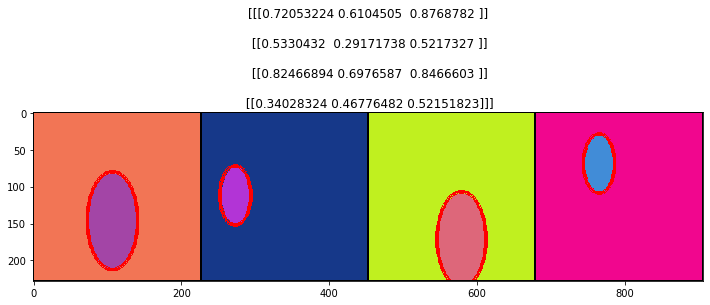

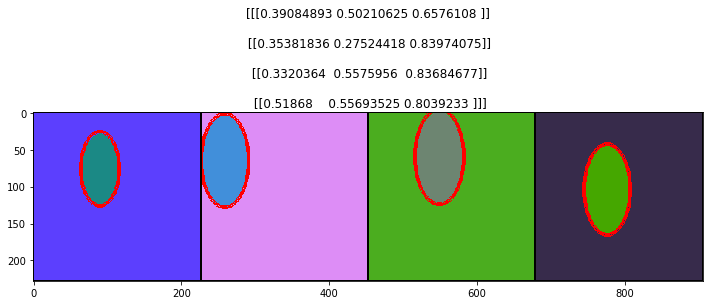

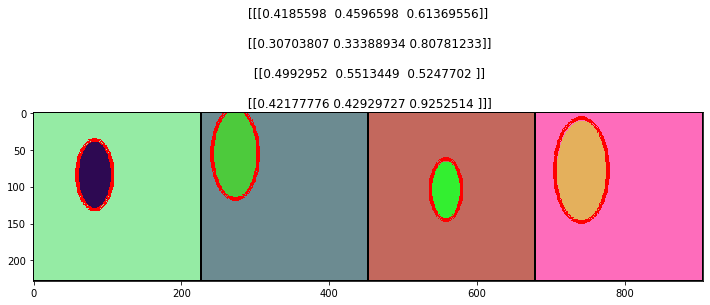

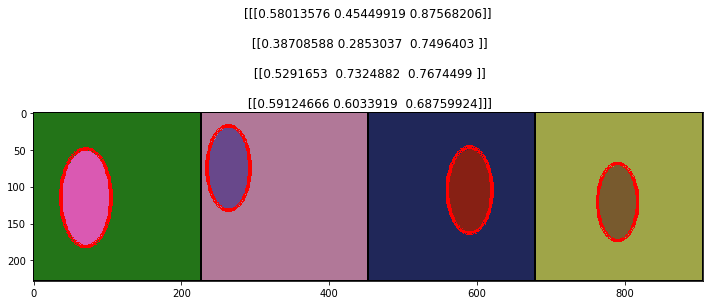

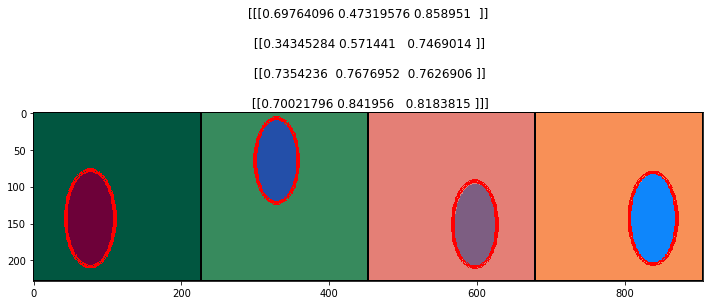

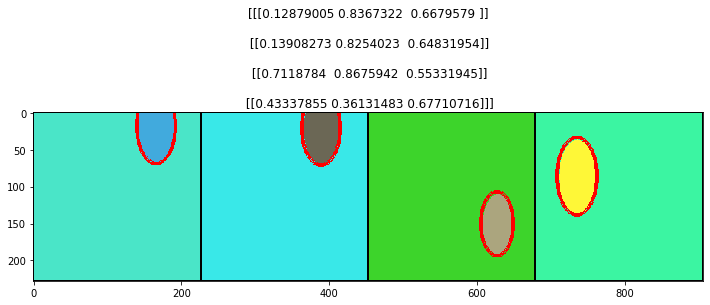

In [29]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.MSELoss()

n_epochs = 25
lr = 0.001

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
#scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
scheduler = onecyclelr.OneCycleLR(optimizer_ft, n_epochs, lr_range=(lr/10, lr))

model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=n_epochs)

visualize_model(model_ft)

## Old result

```
Epoch 16/24
train Loss: 0.0036
val Loss: 0.0031

Epoch 17/24
train Loss: 0.0038
val Loss: 0.0031
```

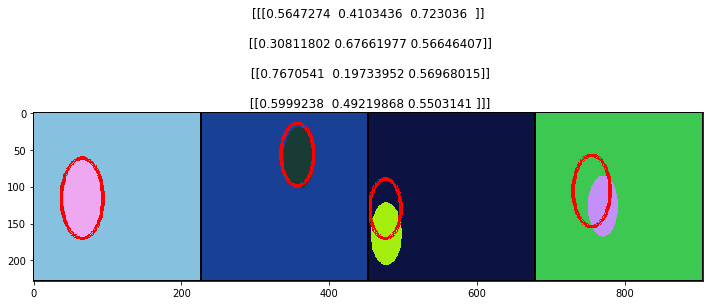

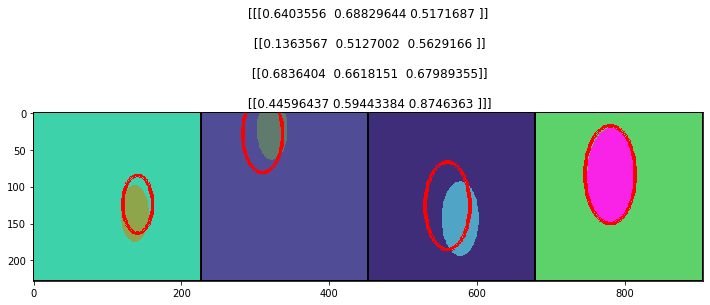

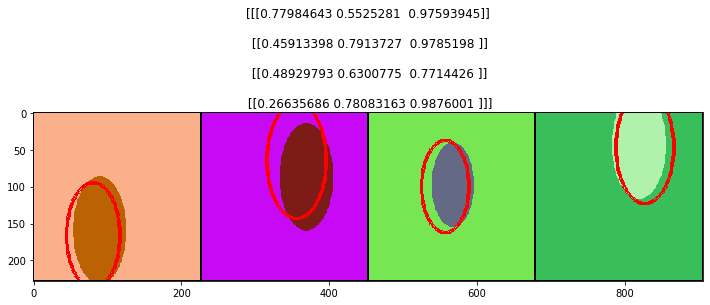

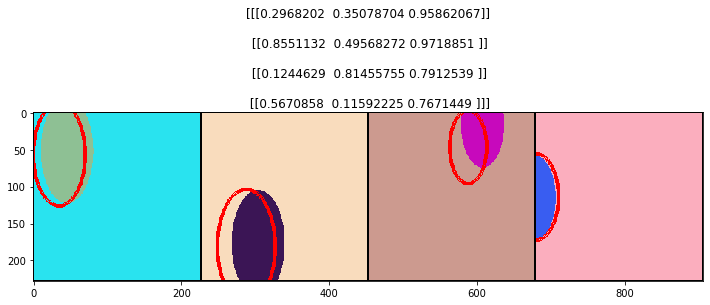

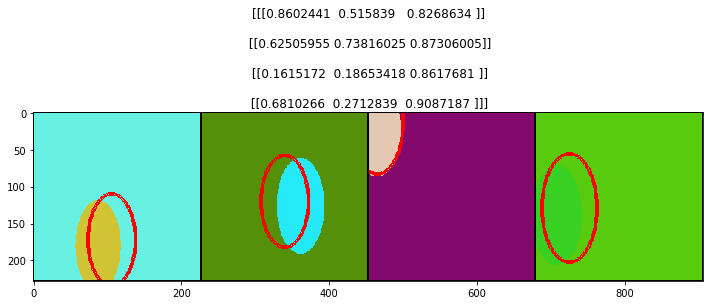

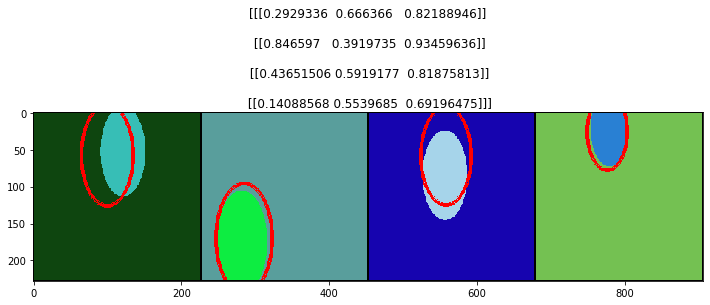

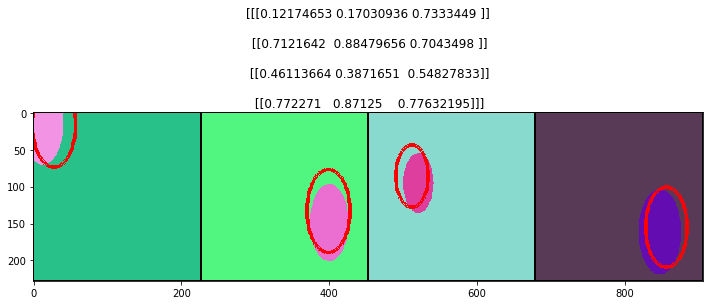

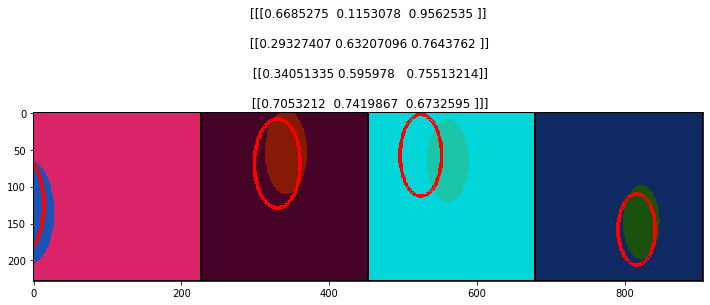

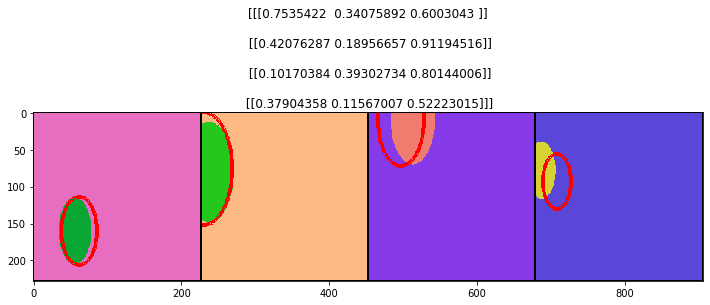

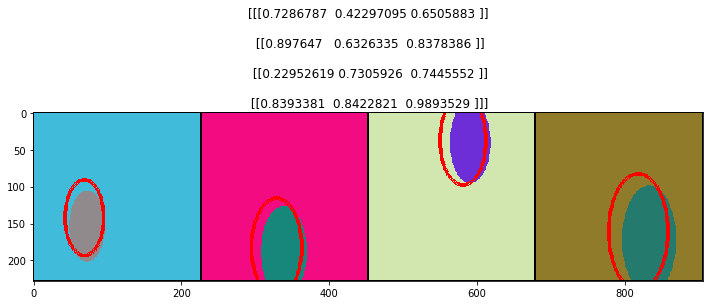

In [50]:
visualize_model(model_ft)